<a href="https://colab.research.google.com/github/jamiekeg/data-science-project/blob/main/Data_Science_Project_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Project

Team Members:
Ignacio, Timothy, Jamie, Megan

...




# Data Exploration and Cleaning

In [2]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Dataset B (Student Engagement)

In [3]:
# Download dataset
df_student = pd.read_csv('/content/UK online student engagement.csv')
df_student

,Unnamed: 0,External,Year,session 1,session 2,test 1,session 3,session 4,test 2,session 5,test 3,session 6,ind cw,group cw,final grade,fourm Q,fourm A,office hour visits,droupout
0,0,N,third,13,20,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,Y
1,1,N,third,71,77,A,40.0,67.0,A,69.0,A,41.0,A,A,D,13,4,4,N
2,2,Y,first,32,62,F,76.0,77.0,A,35.0,F,93.0,F,F,B,16,9,3,N
3,3,Y,first,8,4,F,46.0,36.0,C,93.0,B,79.0,A,D,B,22,4,6,N
4,4,Y,first,6,1,F,23.0,33.0,D,90.0,C,82.0,C,A,C,19,9,7,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11244,11244,Y,second,7,30,D,4.0,35.0,F,28.0,B,91.0,D,D,F,19,7,4,N
11245,11245,Y,third,59,63,A,90.0,40.0,A,57.0,F,93.0,D,C,A,13,6,5,N
11246,11246,Y,third,25,59,C,82.0,33.0,F,77.0,B,56.0,B,F,A,12,9,5,N
11247,11247,N,third,12,13,D,40.0,43.0,D,57.0,B,23.0,D,C,D,12,6,6,N


### Standardizing Data Format

#### Standardize column names

In [4]:
'''Standardizing Column Names'''
# Removing Unnamed: 0 column
df_student = df_student.drop(columns=['Unnamed: 0'])
# Lowercase and remove whitespace from column names
df_student.columns = [col.lower().replace(' ', '_') for col in df_student.columns]
df_student = df_student.rename(columns={'fourm_q':'forum_q', 'fourm_a':'forum_a', 'droupout':'dropout'})

#### Standardize Column Datatypes

In [5]:
non_cont_cols = [name for name in df_student.columns if ('session' not in name)]
for col in non_cont_cols:
    df_student[col] = df_student[col].astype(object)
df_student.dtypes

,0
external,object
year,object
session_1,int64
session_2,int64
test_1,object
session_3,float64
session_4,float64
test_2,object
session_5,float64
test_3,object


#### Check for mismatches

In [6]:
'''Check for mismatched data values'''
for col in df_student.columns:
    if df_student[col].dtype == 'object':
        col_values = df_student[col].unique()
        print(col_values)
  # No values are 'mismatched' (first/second/third, Y/N, and A/B/C/D/F are all present/consistent/no whitespace
  # NaN values will be handled in different phase)

['N' 'Y']
['third' 'first' 'second']
['F' 'A' 'C' 'D' 'B']
[nan 'A' 'C' 'D' 'F' 'B']
[nan 'A' 'F' 'B' 'C' 'D']
[nan 'A' 'F' 'C' 'B' 'D']
[nan 'A' 'F' 'D' 'B' 'C']
[nan 'D' 'B' 'C' 'A' 'F']
[1 13 16 22 19 6 12 4 11 0 8 15 7 18 23 14 3 2 9 10 17 29 24 5 25 20 28 26
 21 27]
[0 4 9 3 8 6 2 1 12 7 22 11 5 17 24 14 15 20 19 10 18 16 13 21 23]
[1 4 3 6 7 0 2 5 8 9]
['Y' 'N']


#### Moving values to more standardized datatypes

In [7]:
# Converting Y/N to True/False, first/second/third to 1/2/3, A/B/C/D/F to 5/4/3/2/1
df_student = df_student.replace({'Y': True, 'N': False, 'first': 1, 'second': 2, 'third': 3, 'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1})

<ipython-input-7-7b7794864b18>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_student = df_student.replace({'Y': True, 'N': False, 'first': 1, 'second': 2, 'third': 3, 'A': 5, 'B': 4, 'C': 3, 'D': 2, 'F': 1})


#### Check for poorly formatted numbers

In [8]:
unformatted_number_count = 0
for val in col_values:
    try:
        test_val = float(val)
        # Checking for decimals
        if val != round(val):
            print(f'Decimal Number: {val}')
            unformatted_number_count += 1
        # Checking for impossible percentages
        if val > 100 or val < 0:
            print(f'Incorrect Number: {val}')
            unformatted_number_count += 1
    except ValueError: #for NaN numbers
        pass
print(f'Unformatted Numbers: {unformatted_number_count}')
# No decimal numbers, no apparent issues with mismatches

Unformatted Numbers: 0


#### Check for duplicates

In [9]:
'''Checking for duplicates'''
duplicates = df_student[df_student.duplicated(keep=False)]
print(duplicates)
# Most likely different students, it would be more suspicious of duplicates were they not all early dropouts or if they were sequential

       external  year  session_1  session_2  test_1  session_3  session_4  \
1127       True     2         14          2       1        NaN        NaN   
1440       True     2         14          2       1        NaN        NaN   
3116       True     1         17         19       1        NaN        NaN   
5592       True     1         17         19       1        NaN        NaN   
7713       True     1         12         14       1        NaN        NaN   
10256      True     1         12         14       1        NaN        NaN   

       test_2  session_5  test_3  session_6  ind_cw  group_cw  final_grade  \
1127      NaN        NaN     NaN        NaN     NaN       NaN          NaN   
1440      NaN        NaN     NaN        NaN     NaN       NaN          NaN   
3116      NaN        NaN     NaN        NaN     NaN       NaN          NaN   
5592      NaN        NaN     NaN        NaN     NaN       NaN          NaN   
7713      NaN        NaN     NaN        NaN     NaN       NaN         

### Adding Session Dropped Column

In [10]:
def get_drop(row):
    if row['dropout'] == False:
        return 5
    if pd.isna(row['session_3']):
        return 1
    if pd.isna(row['session_5']):
        return 2
    if pd.isna(row['session_6']):
        return 3
    else:
        return 4
df_student['session_dropped'] = df_student.apply(get_drop, axis=1)
df_student

,external,year,session_1,session_2,test_1,session_3,session_4,test_2,session_5,test_3,session_6,ind_cw,group_cw,final_grade,forum_q,forum_a,office_hour_visits,dropout,session_dropped
0,False,3,13,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,True,1
1,False,3,71,77,5,40.0,67.0,5.0,69.0,5.0,41.0,5.0,5.0,2.0,13,4,4,False,5
2,True,1,32,62,1,76.0,77.0,5.0,35.0,1.0,93.0,1.0,1.0,4.0,16,9,3,False,5
3,True,1,8,4,1,46.0,36.0,3.0,93.0,4.0,79.0,5.0,2.0,4.0,22,4,6,False,5
4,True,1,6,1,1,23.0,33.0,2.0,90.0,3.0,82.0,3.0,5.0,3.0,19,9,7,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11244,True,2,7,30,2,4.0,35.0,1.0,28.0,4.0,91.0,2.0,2.0,1.0,19,7,4,False,5
11245,True,3,59,63,5,90.0,40.0,5.0,57.0,1.0,93.0,2.0,3.0,5.0,13,6,5,False,5
11246,True,3,25,59,3,82.0,33.0,1.0,77.0,4.0,56.0,4.0,1.0,5.0,12,9,5,False,5
11247,False,3,12,13,2,40.0,43.0,2.0,57.0,4.0,23.0,2.0,3.0,2.0,12,6,6,False,5


In [11]:
df_check = df_student[(pd.isna(df_student['final_grade'])) & ~(pd.isna(df_student['session_6']))]
df_check.size

0

In [12]:
session_cols = [name for name in df_student.columns if ('session' in name)]
for col in session_cols:
    print(f"Column '{col}':")
    print(df_student[col].describe())

Column 'session_1':
count    11249.000000
mean        38.489732
std         30.059852
min          0.000000
25%         10.000000
50%         32.000000
75%         64.000000
max         99.000000
Name: session_1, dtype: float64
Column 'session_2':
count    11249.000000
mean        40.536848
std         28.072742
min          0.000000
25%         14.000000
50%         39.000000
75%         63.000000
max         99.000000
Name: session_2, dtype: float64
Column 'session_3':
count    10309.000000
mean        46.549811
std         27.782394
min          0.000000
25%         23.000000
50%         48.000000
75%         69.000000
max         99.000000
Name: session_3, dtype: float64
Column 'session_4':
count    10309.000000
mean        43.053545
std         23.244112
min          0.000000
25%         26.000000
50%         42.000000
75%         57.000000
max         99.000000
Name: session_4, dtype: float64
Column 'session_5':
count    9063.000000
mean       49.063224
std        25.111657
min  

#### Checking for high correlation columns

In [13]:
'''High Correlation Columns'''
cor_target = abs(df_student.corr(numeric_only=True))
cor_target[cor_target>0.4]

,external,year,session_1,session_2,test_1,session_3,session_4,test_2,session_5,test_3,session_6,ind_cw,group_cw,final_grade,forum_q,forum_a,office_hour_visits,dropout,session_dropped
external,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_1,NaN,NaN,1.000000,0.536096,NaN,0.446564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_2,NaN,NaN,0.536096,1.000000,NaN,0.451841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_3,NaN,NaN,0.446564,0.451841,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
session_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Combining related columns

In [14]:
forum_q_avg = df_student['forum_q'].mean()
forum_a_avg = df_student['forum_a'].mean()
office_hour_visits_avg = df_student['office_hour_visits'].mean()
df_student = df_student.assign(outside_interaction=df_student['forum_q']/forum_q_avg + df_student['forum_a']/forum_a_avg + df_student['office_hour_visits']/office_hour_visits_avg)
df_student = df_student.assign(first_sessions=df_student['session_1']+df_student['session_2'])
df_student = df_student.drop(columns=['forum_q', 'forum_a', 'office_hour_visits','session_1','session_2'])
df_student

,external,year,test_1,session_3,session_4,test_2,session_5,test_3,session_6,ind_cw,group_cw,final_grade,dropout,session_dropped,outside_interaction,first_sessions
0,False,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,0.493747,33
1,False,3,5,40.0,67.0,5.0,69.0,5.0,41.0,5.0,5.0,2.0,False,5,3.847433,148
2,True,1,1,76.0,77.0,5.0,35.0,1.0,93.0,1.0,1.0,4.0,False,5,4.754416,94
3,True,1,1,46.0,36.0,3.0,93.0,4.0,79.0,5.0,2.0,4.0,False,5,5.742345,12
4,True,1,1,23.0,33.0,2.0,90.0,3.0,82.0,3.0,5.0,3.0,False,5,6.599773,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11244,True,2,2,4.0,35.0,1.0,28.0,4.0,91.0,2.0,2.0,1.0,False,5,5.154543,37
11245,True,3,5,90.0,40.0,5.0,57.0,1.0,93.0,2.0,3.0,5.0,False,5,4.564431,122
11246,True,3,3,82.0,33.0,1.0,77.0,4.0,56.0,4.0,1.0,5.0,False,5,4.964123,84
11247,False,3,2,40.0,43.0,2.0,57.0,4.0,23.0,2.0,3.0,2.0,False,5,4.798916,25


## Splitting Dataset

### First Dropout

In [15]:
first_student = df_student
first_student = first_student.assign(dropout=first_student['session_dropped'] < 2)
def divide_interaction_first(row):
    if row['session_dropped'] < 5:
        return row['outside_interaction'] / row['session_dropped']
    else:
        return row['outside_interaction'] / 4
first_student['outside_interaction'] = first_student.apply(divide_interaction_first, axis=1)
first_student = first_student.drop(columns=['session_dropped', 'session_3', 'session_4', 'test_2', 'session_5', 'test_3', 'session_6', 'ind_cw', 'group_cw', 'final_grade'])
first_student

,external,year,test_1,dropout,outside_interaction,first_sessions
0,False,3,1,True,0.493747,33
1,False,3,5,False,0.961858,148
2,True,1,1,False,1.188604,94
3,True,1,1,False,1.435586,12
4,True,1,1,False,1.649943,7
...,...,...,...,...,...,...
11244,True,2,2,False,1.288636,37
11245,True,3,5,False,1.141108,122
11246,True,3,3,False,1.241031,84
11247,False,3,2,False,1.199729,25


#### Dummy Set

In [16]:
first_dummy = first_student.replace({True: 1, False: 0})
first_dummy

<ipython-input-16-faa7a5f4177b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  first_dummy = first_student.replace({True: 1, False: 0})


,external,year,test_1,dropout,outside_interaction,first_sessions
0,0,3,1,1,0.493747,33
1,0,3,5,0,0.961858,148
2,1,1,1,0,1.188604,94
3,1,1,1,0,1.435586,12
4,1,1,1,0,1.649943,7
...,...,...,...,...,...,...
11244,1,2,2,0,1.288636,37
11245,1,3,5,0,1.141108,122
11246,1,3,3,0,1.241031,84
11247,0,3,2,0,1.199729,25


#### PCA

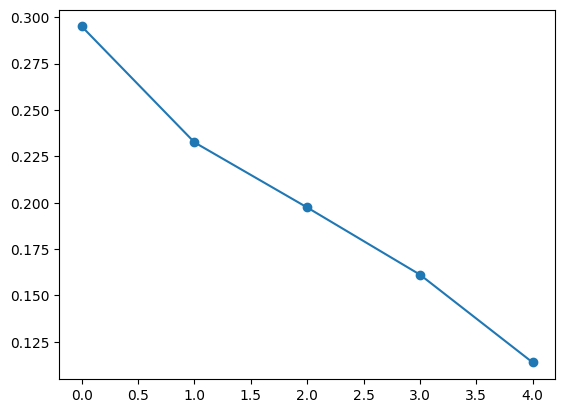

Total variance with 4 components: 0.8861%


In [17]:
scaler = StandardScaler()
pca = PCA(n_components=5)
X_scaled = scaler.fit_transform(first_dummy.drop(columns=['dropout']))
X_pca = pca.fit_transform(X_scaled)
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.show()
total_components = 4
pca_1 = PCA(n_components=total_components)
X_pca_1 = pca_1.fit_transform(X_scaled)
print(f'Total variance with {total_components} components: {pca_1.explained_variance_ratio_.sum():.4f}%')

### Second Dropout

In [18]:
second_student = df_student
second_student = second_student.assign(dropout=second_student['session_dropped'] < 3)
second_student = second_student[second_student['session_dropped'] > 1]
def divide_interaction_second(row):
    return divide_interaction_first(row) * 2
second_student['outside_interaction'] = second_student.apply(divide_interaction_second, axis=1)
second_student = second_student.drop(columns=['session_dropped', 'session_5', 'test_3', 'session_6', 'ind_cw', 'group_cw', 'final_grade'])
second_student

,external,year,test_1,session_3,session_4,test_2,dropout,outside_interaction,first_sessions
1,False,3,5,40.0,67.0,5.0,False,1.923716,148
2,True,1,1,76.0,77.0,5.0,False,2.377208,94
3,True,1,1,46.0,36.0,3.0,False,2.871173,12
4,True,1,1,23.0,33.0,2.0,False,3.299886,7
5,False,3,5,15.0,69.0,1.0,False,1.246757,154
...,...,...,...,...,...,...,...,...,...
11244,True,2,2,4.0,35.0,1.0,False,2.577271,37
11245,True,3,5,90.0,40.0,5.0,False,2.282216,122
11246,True,3,3,82.0,33.0,1.0,False,2.482062,84
11247,False,3,2,40.0,43.0,2.0,False,2.399458,25


#### Dummy Set

In [19]:
second_dummy = second_student.replace({True: 1, False: 0})
second_dummy

<ipython-input-19-db3a944aef35>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  second_dummy = second_student.replace({True: 1, False: 0})


,external,year,test_1,session_3,session_4,test_2,dropout,outside_interaction,first_sessions
1,0,3,5,40.0,67.0,5.0,0,1.923716,148
2,1,1,1,76.0,77.0,5.0,0,2.377208,94
3,1,1,1,46.0,36.0,3.0,0,2.871173,12
4,1,1,1,23.0,33.0,2.0,0,3.299886,7
5,0,3,5,15.0,69.0,1.0,0,1.246757,154
...,...,...,...,...,...,...,...,...,...
11244,1,2,2,4.0,35.0,1.0,0,2.577271,37
11245,1,3,5,90.0,40.0,5.0,0,2.282216,122
11246,1,3,3,82.0,33.0,1.0,0,2.482062,84
11247,0,3,2,40.0,43.0,2.0,0,2.399458,25


#### PCA

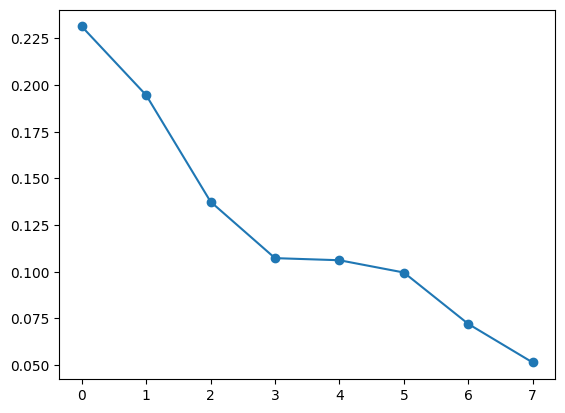

Total variance with 6 components: 0.8765%


In [20]:
scaler = StandardScaler()
pca = PCA(n_components=8)
X_scaled = scaler.fit_transform(second_dummy.drop(columns=['dropout']))
X_pca = pca.fit_transform(X_scaled)
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.show()
total_components = 6
pca_2 = PCA(n_components=total_components)
X_pca_2 = pca_2.fit_transform(X_scaled)
print(f'Total variance with {total_components} components: {pca_2.explained_variance_ratio_.sum():.4f}%')

### Third Dropout

In [21]:
third_student = df_student
third_student = third_student.assign(dropout=third_student['session_dropped'] < 4)
third_student = third_student[third_student['session_dropped'] > 2]
def divide_interaction_third(row):
    return divide_interaction_first(row) * 3
third_student['outside_interaction'] = third_student.apply(divide_interaction_third, axis=1)
third_student = third_student.drop(columns=['session_dropped', 'session_6', 'ind_cw', 'group_cw', 'final_grade'])
third_student

,external,year,test_1,session_3,session_4,test_2,session_5,test_3,dropout,outside_interaction,first_sessions
1,False,3,5,40.0,67.0,5.0,69.0,5.0,False,2.885575,148
2,True,1,1,76.0,77.0,5.0,35.0,1.0,False,3.565812,94
3,True,1,1,46.0,36.0,3.0,93.0,4.0,False,4.306759,12
4,True,1,1,23.0,33.0,2.0,90.0,3.0,False,4.949830,7
5,False,3,5,15.0,69.0,1.0,67.0,1.0,True,1.870135,154
...,...,...,...,...,...,...,...,...,...,...,...
11244,True,2,2,4.0,35.0,1.0,28.0,4.0,False,3.865907,37
11245,True,3,5,90.0,40.0,5.0,57.0,1.0,False,3.423323,122
11246,True,3,3,82.0,33.0,1.0,77.0,4.0,False,3.723092,84
11247,False,3,2,40.0,43.0,2.0,57.0,4.0,False,3.599187,25


#### Dummy Set

In [22]:
third_dummy = third_student.replace({True: 1, False: 0})
third_dummy

<ipython-input-22-59c2acd3f109>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  third_dummy = third_student.replace({True: 1, False: 0})


,external,year,test_1,session_3,session_4,test_2,session_5,test_3,dropout,outside_interaction,first_sessions
1,0,3,5,40.0,67.0,5.0,69.0,5.0,0,2.885575,148
2,1,1,1,76.0,77.0,5.0,35.0,1.0,0,3.565812,94
3,1,1,1,46.0,36.0,3.0,93.0,4.0,0,4.306759,12
4,1,1,1,23.0,33.0,2.0,90.0,3.0,0,4.949830,7
5,0,3,5,15.0,69.0,1.0,67.0,1.0,1,1.870135,154
...,...,...,...,...,...,...,...,...,...,...,...
11244,1,2,2,4.0,35.0,1.0,28.0,4.0,0,3.865907,37
11245,1,3,5,90.0,40.0,5.0,57.0,1.0,0,3.423323,122
11246,1,3,3,82.0,33.0,1.0,77.0,4.0,0,3.723092,84
11247,0,3,2,40.0,43.0,2.0,57.0,4.0,0,3.599187,25


#### PCA

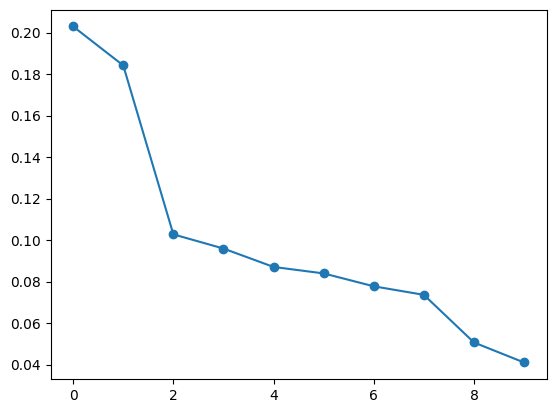

Total variance with 7 components: 0.8347%


In [23]:
scaler = StandardScaler()
pca = PCA(n_components=10)
X_scaled = scaler.fit_transform(third_dummy.drop(columns=['dropout']))
X_pca = pca.fit_transform(X_scaled)
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.show()
total_components = 7
pca_3 = PCA(n_components=total_components)
X_pca_3 = pca_3.fit_transform(X_scaled)
print(f'Total variance with {total_components} components: {pca_3.explained_variance_ratio_.sum():.4f}%')

# Unit Tests

# Heatmap/Correlation Matrix




# Modeling

### Visualizing Datasets

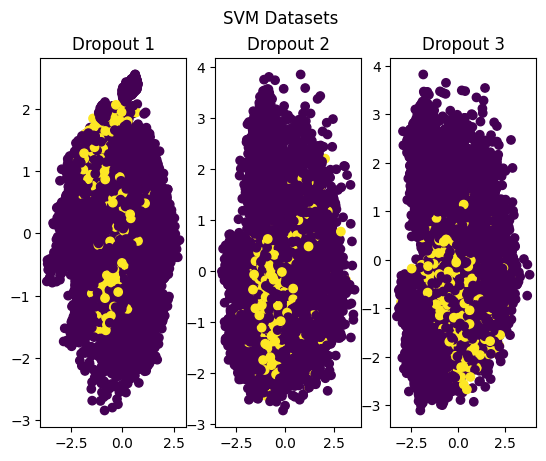

In [24]:
datasets = {1: (X_pca_1, first_dummy['dropout']), 2: (X_pca_2, second_dummy['dropout']), 3: (X_pca_3, third_dummy['dropout'])}
graphing_datasets = X_pca_1[:,0], X_pca_2[:1]
fig, axes = plt.subplots(1, 3)
fig.suptitle('SVM Datasets')
for ix, (X, y) in enumerate(datasets.values(), start=0):
    axes[ix].scatter(X[:,0], X[:,1], c=y)
    axes[ix].set_title(f'Dropout {ix+1}')
plt.show()

##Model 4: XGBoost

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


🔥 XGBoost on Dataset 1
Accuracy: 0.9222
Precision: 0.5143
Recall (Sensitivity): 0.8804
F1-Score: 0.6493


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:39:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


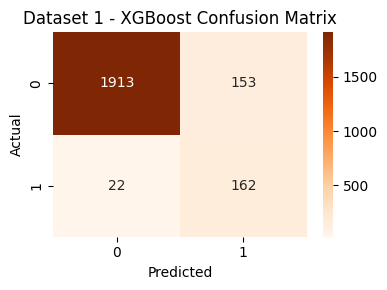

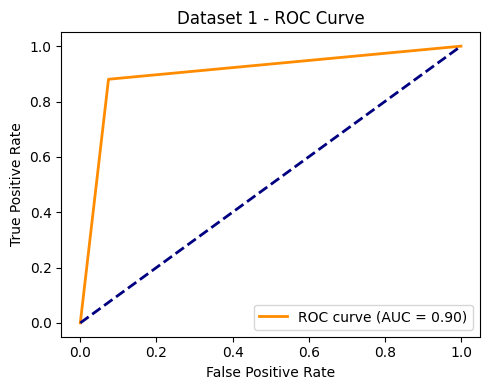


🔥 XGBoost on Dataset 2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:39:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9025
Precision: 0.5738
Recall (Sensitivity): 0.8235
F1-Score: 0.6763


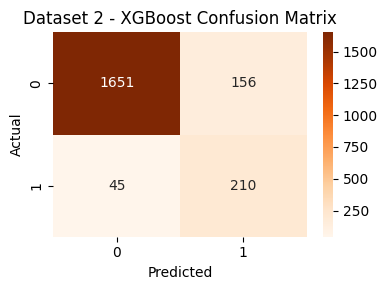

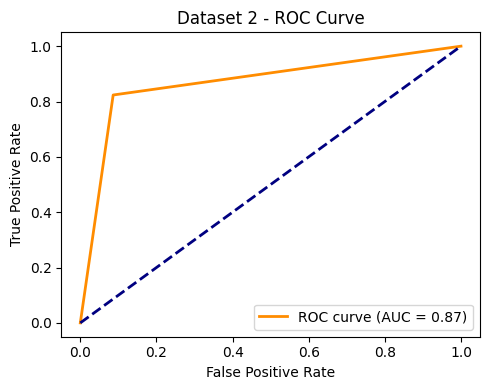


🔥 XGBoost on Dataset 3


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:39:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8792
Precision: 0.4743
Recall (Sensitivity): 0.7772
F1-Score: 0.5891


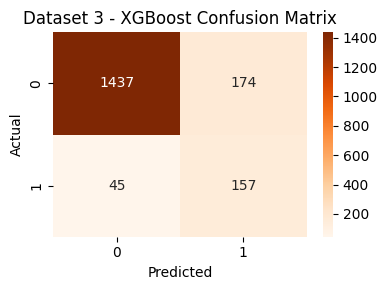

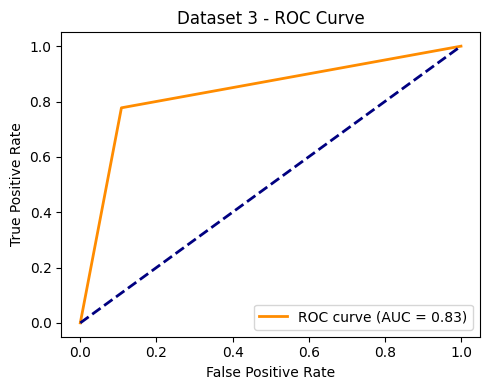

In [28]:
for ix, (X, y) in enumerate(datasets.values(), start=1):
    print(f"\n🔥 XGBoost on Dataset {ix}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # XGBoost model
    xgb = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # handle class imbalance
    )
    xgb.fit(X_train, y_train)

    # Predictions
    y_pred = xgb.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall (Sensitivity): {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title(f"Dataset {ix} - XGBoost Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Dataset {ix} - ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()